# 2 hidden layer perceptron for 1D regression with different SGD variants

In [17]:
import numpy as np
import matplotlib.pyplot as plt
#Pandas for data managment
import pandas as pd
#figures in notebook
%matplotlib inline
#larger figures
plt.rcParams['figure.figsize'] = [10, 5]

# Implementation of the neural network

The Goal of this network is to predict a scalar as output given a scalar as input. In other word it has to find a mapping between f from [0,1] to [0,1] which minimizes the L2 loss of the input data.
This problem can be seen as an interpolation or a regression problem.

In [6]:
#Activation functions
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

#Neural Network
class Neural_Network(object):
    def __init__(self,learningRateGrad=3.0,momentum=0.1,loopsGrad=1000,hiddenLayers=15,hiddenLayers2=15):
        '''Initialisation of the class
        Learning rate is the learning rate for both momentum and adagrad optimisations
        Momentum term only for SGD momentum ignored in other optimisations
        loopsGrad is the number of "epochs" but here the training is full batch (using all data at once) every iteration
        The two last parameters are the number of neuron on each of the hidden Layer'''
        
        #Hyperparameters
        #eps so no overflow in adagrad
        self.eps = np.finfo(np.float).eps
        #input and output are scalar
        self.inputLayerSize = 1
        self.outputLayerSize = 1
        #Hidden layers sizes are chosen by the user
        self.hiddenLayerSize = hiddenLayers
        self.hiddenLayerSize2 =hiddenLayers2
        
        #Optimisation hyperparameters
        self.learningRate = learningRateGrad
        self.momentum = momentum
        self.maxRange=loopsGrad
        
        #Saving loss for plotting
        self.costArray=[]
        
        #Initialize Weights
        #The seed can be modified if necessary
        np.random.seed(2)
        
        #Rough initialisation of weights with Gaussians (usually the variance should be different between layers)
        #or include batch Normalization layers. In our case the network is small enough and the task is simple enough.
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.hiddenLayerSize2)
        self.W3 = np.random.randn(self.hiddenLayerSize2,self.outputLayerSize)
        
        #Initialisation of the biaises with zeros
        self.B2 = np.zeros([1,self.hiddenLayerSize])
        self.B3 = np.zeros([1,self.hiddenLayerSize2])
        self.Boutput = np.zeros([1,self.outputLayerSize])
        
    def forward(self, X):
        '''Forward pass of data through the network'''
        #Computes Zi+1 = ai.Wi + Bi+1
        #Computes ai+1 = activation(Zi+1)
        
        self.z2 = np.dot(X, self.W1) + self.B2
        self.a2 = sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.B3
        self.a3 = sigmoid(self.z3)
        self.z4 = np.dot(self.a3,self.W3) + self.Boutput
        yHat = sigmoid(self.z4)
        
        #returns expected value yhat
        return yHat
    
    def costFunction(self, X, y):
        '''Cost function is L2 loss, the 0.5 term is so that the derivative of the cost is just yhat-y
        This function is only useful for checking performance because
        the training process only uses the first order derivative form'''
        
        self.yHat = self.forward(X)
        return(np.sum(0.5*(y-self.yHat)**2))
        
    def costFunctionPrime(self, X, y):
        '''Computes derivative of the error (yHat) and backpropagate it throught the network'''
        #Optaining the expected values for the set of examples
        self.yHat = self.forward(X)
        
        #Bit of calculus for backpropagation
        #The derivative of the error to backpropagate is yhat - y
        #delta is the contribution to the error of the activation of the last layer as well as the one of the biais
        #dJdWi is the contribution of the weights to the error
        
        #Could be implemented recursively but I don't really like recursion.
        delta4 = np.multiply(-(y-self.yHat), sigmoidPrime(self.z4))
        dJdW3 = np.dot(self.a3.T, delta4)
        
        delta3 = np.dot(delta4, self.W3.T)*sigmoidPrime(self.z3)
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        
        #Returns the contribution of the weigths and biaises so they can be updated in the train function
        return dJdW1, dJdW2, dJdW3, np.sum(delta2), np.sum(delta3), np.sum(delta4)
    
    def train(self,x,y):
        '''This train method updates the weights and biases using vanilla SGD'''
        #Max range is the number 
        for i in range(self.maxRange):
            #Apply basic Gradient Descent, the modify the weight by going the opposite way of gradient
            dJdW1, dJdW2, dJdW3, delta2, delta3, delta4 = self.costFunctionPrime(x, y)
            self.W1 += -self.learningRate*dJdW1
            self.W2 += -self.learningRate*dJdW2
            self.W3 += -self.learningRate*dJdW3

            self.B2 += -self.learningRate*delta2
            self.B3 += -self.learningRate*delta3
            self.Boutput += -self.learningRate*delta4
            self.costArray.append(self.costFunction(x,y))
    
    def trainMomentum(self,x,y):
        '''Training method using momentum SGD'''
        #Initialize memory
        precedentUp1=np.zeros([self.inputLayerSize,self.hiddenLayerSize])
        precedentUp2=np.zeros([self.hiddenLayerSize,self.hiddenLayerSize2])
        precedentUp3=np.zeros([self.hiddenLayerSize2,self.outputLayerSize])
        precedentUpBias2=np.zeros([1,self.hiddenLayerSize])
        precedentUpBias3=np.zeros([1,self.hiddenLayerSize2])
        precedentUpBiasOut=np.zeros([1,self.outputLayerSize])
        
        #maxRange is the number of training iteration
        for i in range(self.maxRange):
            #Compute the initial update
            dJdW1, dJdW2, dJdW3, delta2, delta3, delta4 = self.costFunctionPrime(x, y)
            update1 = self.learningRate*dJdW1
            update2 = self.learningRate*dJdW2
            update3 = self.learningRate*dJdW3
            updateBias2 = self.learningRate*delta2
            updateBias3 = self.learningRate*delta3
            updateBiasOut = self.learningRate*delta4
            
            #Compute velocity
            velocity1 = precedentUp1*self.momentum
            velocity2 = precedentUp2*self.momentum
            velocity3 = precedentUp3*self.momentum
            velocityBias2 = precedentUpBias2*self.momentum
            velocityBias3 = precedentUpBias3*self.momentum
            velocityBiasOut = precedentUpBiasOut*self.momentum
            
            #Update the weights and biases by correcting the update with the velocity
            self.W1 = self.W1 - velocity1 - update1
            self.W2 = self.W2 - velocity2 - update2
            self.W3 = self.W3 - velocity3 - update3
            self.B2 = self.B2 - velocityBias2 - updateBias2
            self.B3 = self.B3 - velocityBias3 - updateBias3
            self.Boutput = self.Boutput - velocityBiasOut - updateBiasOut
            
            #Save the last update for the next velocity
            precedentUp1 = update1
            precedentUp2 = update2
            precedentUp3 = update3
            precedentUpBias2 = updateBias2
            precedentUpBias3 = updateBias3
            precedentUpBiasOut = updateBiasOut
            self.costArray.append(self.costFunction(x,y))
                
    def trainADAGRAD(self,x,y):
        '''Training using the Adagrad SGD
        Adagrad means adaptative gradient
        Dampens the learning rate over time (individually for each parameter)'''
        
        #Initialization of the last update
        precedentUp1=np.zeros([self.inputLayerSize,self.hiddenLayerSize])
        precedentUp2=np.zeros([self.hiddenLayerSize,self.hiddenLayerSize2])
        precedentUp3=np.zeros([self.hiddenLayerSize2,self.outputLayerSize])
        precedentUpBias2=np.zeros([1,self.hiddenLayerSize])
        precedentUpBias3=np.zeros([1,self.hiddenLayerSize2])
        precedentUpBiasOut=np.zeros([1,self.outputLayerSize])
        
        #maxRange is the number of training iteration
        for i in range(self.maxRange):
            
            #Compute the update for adagrad
            dJdW1, dJdW2, dJdW3, delta2, delta3, delta4 = self.costFunctionPrime(x, y)
            gradCompo1 = precedentUp1+dJdW1*dJdW1
            gradCompo2 = precedentUp2+dJdW2*dJdW2
            gradCompo3 = precedentUp3+dJdW3*dJdW3
            gradCompoBias2 = precedentUpBias2+delta2*delta2
            gradCompoBias3 = precedentUpBias3+delta3*delta3
            gradCompoBiasOut = precedentUpBiasOut+delta4*delta4
            
            adpt1 = self.learningRate*dJdW1/(np.sqrt(gradCompo1)+self.eps)
            adpt2 = self.learningRate*dJdW2/(np.sqrt(gradCompo2)+self.eps)
            adpt3 = self.learningRate*dJdW3/(np.sqrt(gradCompo3)+self.eps)
            adptBias2 = self.learningRate*delta2/(np.sqrt(gradCompoBias2)+self.eps)
            adptBias3 = self.learningRate*delta3/(np.sqrt(gradCompoBias3)+self.eps)
            adptBiasOut = self.learningRate*delta4/(np.sqrt(gradCompoBiasOut)+self.eps)
            
            #Update parameters
            self.W1 = self.W1 - adpt1
            self.W2 = self.W2 - adpt2
            self.W3 = self.W3 - adpt3
            self.B2 = self.B2 - adptBias2
            self.B3 = self.B3 - adptBias3
            self.Boutput = self.Boutput - adptBiasOut
            
            #Save the last update for the next velocity
            precedentUp1 = gradCompo1
            precedentUp2 = gradCompo2
            precedentUp3 = gradCompo3
            precedentUpBias2 = gradCompoBias2
            precedentUpBias3 = gradCompoBias3
            precedentUpBiasOut = gradCompoBiasOut
            self.costArray.append(self.costFunction(x,y))


# 1D toy example

The goal of this example is to fit/overfit some 1D data. The data to overfit is a function between 0 and 0.7
(not 1 and exactly 0 to avoid the saturation in the sigmoids)

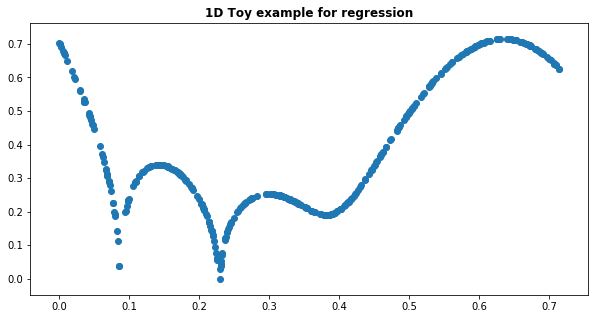

In [7]:
#Generate a 1D data set

#scale is x and Input is f(x)
#generate 50 points between 0 and 1.0
scale=np.array([np.linspace(0.0,1.0,50)]).T

#Resize between 0-0.7 to avoid issues with saturation of the sigmoid
scale = scale-np.amin(scale, axis=0)
scale= scale/(1.4*np.amax(scale, axis=0))


points=400
def function_to_fit(x):
    '''Function for toy example'''
    return ((((np.sin(x)*x**2+x) -2*x*np.cos(x) +1 +x**2))**2)**(1/6.0)

#Generate data points
scale=np.random.rand(1,points).T*8-4
Input=function_to_fit(scale)

#Resize between 0-0.7 to avoid issues with saturation of the sigmoid
Input = Input-np.amin(Input, axis=0)
Input= Input/(1.4*np.amax(Input, axis=0))

#Resize between 0-0.7 to avoid issues with saturation of the sigmoid
scale = scale-np.amin(scale, axis=0)
scale= scale/(1.4*np.amax(scale, axis=0))

#Plot the toy function
plt.scatter(scale,Input)
plt.title("1D Toy example for regression",fontweight='bold')
plt.show()

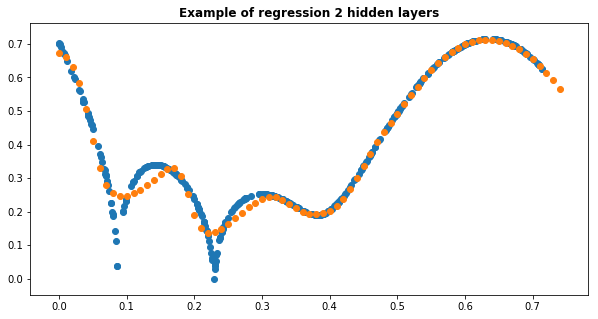

In [8]:
#Create Neural Network
#LR = 0.8, iteration 20000, 1st hidden layer 15 neurons, 2nd hidden layer 15 neurons. 
NN=Neural_Network(0.8,0,20000,15,15)

#Train with SGD adagrad
NN.trainADAGRAD(scale,Input)

#Preparing plots
X = np.arange(0, 0.75, 0.01,dtype=np.float)
Z=np.zeros_like(X)
plt.figure()

for i in range(len(X)):
    Z[i]=NN.forward([X[i]])

#plotting toy function
plt.scatter(scale,Input)
#plotting the fit
plt.scatter(X,Z)
plt.title('Example of regression 2 hidden layers',fontweight='bold')
plt.show()

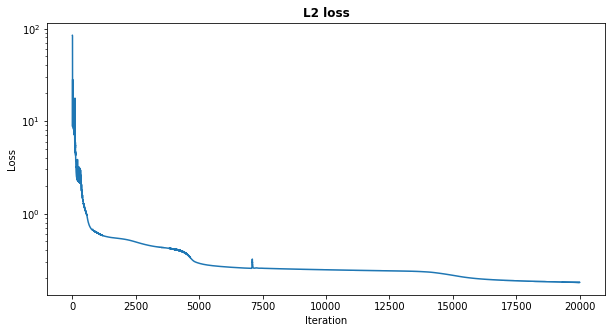

In [9]:
#plot cost over time
plt.plot(range(len(NN.costArray)),NN.costArray,label=str(i))
plt.title('L2 loss',fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.yscale('log')
plt.show()

0.025
0.08
0.3
0.7
0.9
1.3


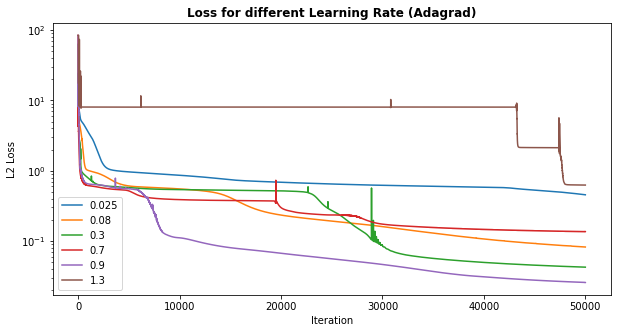

In [10]:
'''This cell can be a little slow to run because the algorithm runs 50 000 for each learning rate
(running for 6 diffrent ones)'''

plt.figure()
#RegressionList stores the results of fitting for each Neural Networks
RegressionList = []
#Test set is the input for the forward pass ()
TestSet = np.arange(0, 0.75, 0.01,dtype=np.float).reshape(len(np.arange(0, 0.75, 0.01,dtype=np.float)),1)
#A List of a few learning rate
LearningRateArrayA=[0.025,0.08,0.3,0.7,0.9,1.3]

for i in LearningRateArrayA:
    #Print out the learning rate to show that the computer is actually doing its job
    print(i)
    #Create the neural network
    NN=Neural_Network(i,0,50000,15,15)
    #Train using adagrad
    NN.trainADAGRAD(scale,Input)
    #Forward pass
    RegressionList.append(NN.forward(TestSet))
    #plot the loss for every learning rate
    plt.plot(range(len(NN.costArray)),NN.costArray,label=str(i))
    plt.yscale('log')
plt.legend()
plt.title('Loss for different Learning Rate (Adagrad)',fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('L2 Loss')
plt.show()

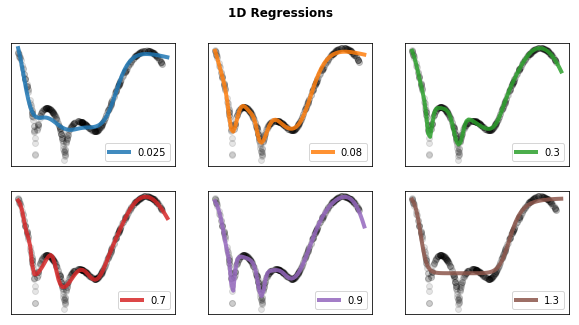

In [11]:
#Plot the fitting for each learning rate
colorList = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i in range(len(RegressionList)):
    #Indexing the subplot
    plt.subplot(231+i)
    #lw is line width
    #aplha is transparency
    plt.plot(scale,Input,'o',color='black',alpha = 0.1)
    plt.plot(TestSet,RegressionList[i],'-', color = colorList[i],lw='4', alpha=0.85,label=str(LearningRateArrayA[i]))
    #No numeric values on the axis
    plt.xticks([])
    plt.yticks([])
    plt.legend()
plt.suptitle("1D Regressions",fontweight='bold')
plt.show()

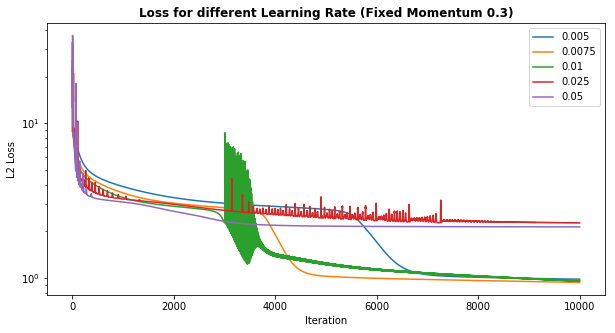

In [12]:
#Plot the loss for a fixed momentum (0.3) and multiple learning rate.
# In this case we can see some oscillating state
LearningRateArrayM=[0.005,0.0075,0.01,0.025,0.05]
for i in LearningRateArrayM:
    #Create neural network
    NN=Neural_Network(i,0.3,10000,15,15)
    #Train with momentum
    NN.trainMomentum(scale,Input)
    #plot l2 loss for each learning rate
    plt.plot(range(len(NN.costArray)),NN.costArray,label=str(i))
    plt.yscale('log')
plt.legend()
plt.title('Loss for different Learning Rate (Fixed Momentum 0.3)',fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('L2 Loss')
plt.show() 

# Real data for 1D regression

In this example, we take real data and try to do a regression/interpolation task. The data is CO2 emission,
global temperatures and years. Only the features C02 emissions and temperatures are kept.

In [13]:
# Import data
co2_df = pd.read_csv('global.csv')
temp_df = pd.read_csv('annual.csv')

# Clean data
co2_df = co2_df.iloc[:,:2]                     # Keep only total CO2
co2_df = co2_df.loc[co2_df['Year'] >= 1960]   # Keep only 1960 - 2010
co2_df.columns=['Year','CO2']                # Rename columns
co2_df = co2_df.reset_index(drop=True)                # Reset index

co2_df.head()

temp_df = temp_df[temp_df.Source != 'GISTEMP']                              # Keep only one source
temp_df.drop('Source', inplace=True, axis=1)                                # Drop name of source
temp_df = temp_df.reindex(index=temp_df.index[::-1])                        # Reset index
temp_df = temp_df.loc[temp_df['Year'] >= 1960].loc[temp_df['Year'] <= 2010]   # Keep only 1960 - 2010
temp_df.columns=['Year','Temperature']                                      # Rename columns
temp_df = temp_df.reset_index(drop=True)                                             # Reset index

temp_df.head()

climate_change_df = pd.concat([co2_df, temp_df.Temperature], axis=1)

#Preprocess the data (scale between 0 and 0.75)
Dinput=np.array([climate_change_df['Temperature']]).T
Doutput=np.array([climate_change_df['CO2']],dtype=np.float).T
Dinput= Dinput-np.amin(Dinput, axis=0)
Dinput= Dinput/(1.4*np.amax(Dinput, axis=0))
Doutput= Doutput-np.amin(Doutput.ravel())
Doutput=Doutput/(1.4*np.max(Doutput.ravel()))

climate_change_df.head()

,Year,CO2,Temperature
0,1960,2569,0.0204
1,1961,2580,0.0775
2,1962,2686,0.0888
3,1963,2833,0.1068
4,1964,2995,-0.1495


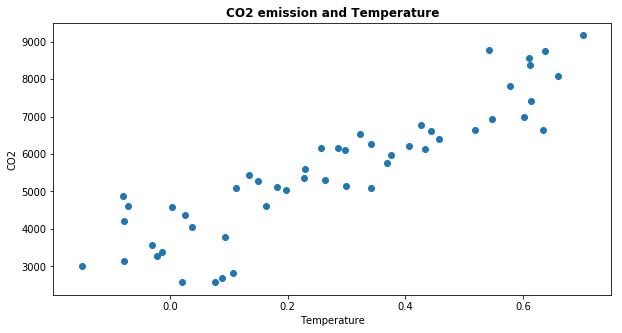

In [14]:
#show the original plot for C02 and temperature
plt.scatter(climate_change_df['Temperature'],climate_change_df['CO2'])
plt.title("CO2 emission and Temperature",fontweight='bold')
plt.xlabel("Temperature")
plt.ylabel("CO2")
plt.show()

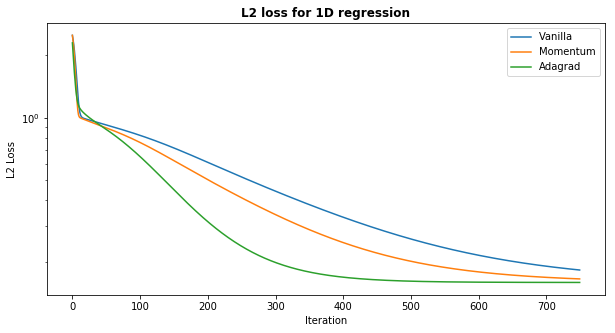

In [15]:
#Fitting the data using 3 optimisation methods

#Define hyperparameters
LearningRate=0.02
Momentum=0.3
loops=750
neurons=15

#Test values for forward pass
TestSet1 = np.arange(0, 0.75, 0.025,dtype=np.float).reshape(len(np.arange(0, 0.75, 0.025,dtype=np.float)),1)

#Instantiating the NN and training it with vanilla SGD
NN=Neural_Network(LearningRate,Momentum,loops,neurons,neurons)
NN.train(Dinput,Doutput)
OutputVanilla = NN.forward(TestSet1)
plt.plot(range(len(NN.costArray)),NN.costArray,label='Vanilla')

#Instantiating the NN and training it with Momentum SGD
NN=Neural_Network(LearningRate,Momentum,loops,neurons,neurons)
NN.trainMomentum(Dinput,Doutput)
OutputMomentum = NN.forward(TestSet1)
plt.plot(range(len(NN.costArray)),NN.costArray,label='Momentum')

#Instantiating the NN and training it with adagrad SGD
NN=Neural_Network(LearningRate,Momentum,loops,neurons,neurons)
NN.trainADAGRAD(Dinput,Doutput)
OutputAdagrad = NN.forward(TestSet1)
plt.plot(range(len(NN.costArray)),NN.costArray,label='Adagrad')

#semilog plot
plt.yscale('log')
plt.legend()
plt.title('L2 loss for 1D regression',fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('L2 Loss')
plt.show()

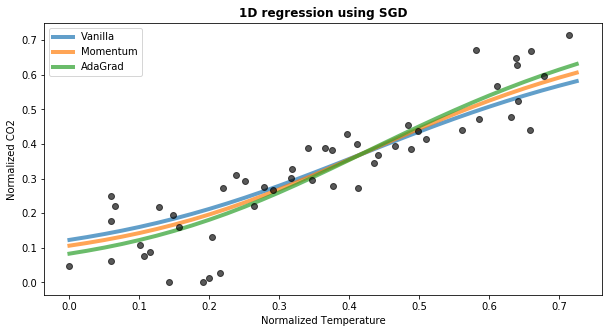

In [16]:
#Ploting the fitting using the outputs of the forward passes
#lw is line width
#aplha is transparency
plt.plot(TestSet1,OutputVanilla,'-', lw='4', alpha=0.7,label='Vanilla')
plt.plot(TestSet1,OutputMomentum,'-', lw='4', alpha=0.7,label='Momentum')
plt.plot(TestSet1,OutputAdagrad,'-', lw='4', alpha=0.7,label='AdaGrad')
plt.plot(Dinput,Doutput,'o',color='black',alpha = 0.65)
plt.legend()
plt.title('1D regression using SGD',fontweight='bold')
plt.xlabel('Normalized Temperature')
plt.ylabel('Normalized CO2')
plt.show()